# 最佳化演算法案例

<hr>

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import shutil
import imageio
import random
import copy
import time
import sys
import math
import tkinter #//GUI模块
import threading
from functools import reduce
from IPython.display import Image

# CH0 - 最佳化問題

- 旅行推銷員問題 travelling salesman problem, TSP
<br>
https://zh.wikipedia.org/wiki/%E6%97%85%E8%A1%8C%E6%8E%A8%E9%94%80%E5%91%98%E9%97%AE%E9%A2%98
- 車輛路線問題
<br>
https://wiki.mbalib.com/zh-tw/%E6%9C%89%E6%97%B6%E9%97%B4%E7%AA%97%E8%BD%A6%E8%BE%86%E8%B7%AF%E5%BE%84%E9%97%AE%E9%A2%98
- 其他

# CH1 - 演算法介紹
- ACO 蟻群演算法
- GA 遺傳演算法
- EP 進化規劃 Evolution Programming
- SA 模擬退火演算法
- 反作用搜尋
- TS 禁忌搜尋
- AIS 人工免疫系統
- PSO 粒子群最佳化
- GSA 引力搜尋演算法
- ACCM 蟻群群集方法
- SDS 隨機傳播搜尋
- NN 類神經網路
- https://zh.wikipedia.org/wiki/%E8%9A%81%E7%BE%A4%E7%AE%97%E6%B3%95

### 導引模擬退火演算法 Guided Simulated Annealing
基本上就是模擬退火與遺傳演算法的結合，
於模擬退火的基礎上加入導引函數，
而導引函數則是表示多樣本組成的機率分配，
與Grid Search搭配Bayesian Optimization的概念很類似。

# CH2 - 使用演算法進行中文斷詞

## 退火演算法


In [3]:
# General Function
def create_data(N, xu=100, yu=100, xd=-100, yd=-100):
    def generate_data(data_upper, data_lower):
        return random.random() * (data_upper - data_lower) + data_lower
    
    def get_distance(x, y):
        return np.sqrt((x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2) 
    # 所謂的 List comprehension
    points = [(generate_data(xu, xd), generate_data(yu, yd)) for i in range(N)]
    Mat = np.zeros((N, N))
    for i in range(N):
        for j in range(i + 1, N):
            dv = get_distance(points[i], points[j])
            Mat[i][j], Mat[j][i] = dv, dv
    return points, Mat


In [4]:
class SAA:
    def __init__(self):
        self.TIMESIT = 0
        self.PNGFILE = './png/'
        self.PNGLIST = []
        self.temp_path = []
        self.temp_value = 0
        self.T = 1000  # 起始溫度
        self.limitedT = 1.  # 最小值的T
        self.alpha = 0.9  # T_{k+1} = alpha * T_k方式更新溫度，有點像learning rate的概念但不全是。
        self.iterTime = 1000  # 每個溫度下迭代的次數，類似epoch或是GA的population。
        self.K = 1.5  # 係數K
        
    @staticmethod
    def calculate_path_value(path, Mat):
        path_value = Mat[0][path[0]]
        for i in range(len(path) - 1):
            path_value += Mat[path[i]][path[i + 1]]
        path_value += Mat[path[-1]][0]
        return path_value

    def initial(self, N, Mat):
        init = list(range(1, N, 1))
        random.shuffle(init)
        init_value = self.calculate_path_value(init, Mat)
        return init, init_value

    def draw(self, path, pv, N):
        plt.cla()
        plt.title('cross=%.4f' % pv)
        xs = [p[0] for p in points]
        ys = [p[1] for p in points]
        plt.scatter(xs, ys, color='b')
        xs = np.array(xs)
        ys = np.array(ys)
        plt.plot(xs[[0, path[0]]], ys[[0, path[0]]], color='r')
        for i in range(N - 2):
            plt.plot(xs[[path[i], path[i + 1]]], ys[[path[i], path[i + 1]]], color='r')
        plt.plot(xs[[path[N - 2], 0]], ys[[path[N - 2], 0]], color='r')
        plt.scatter(xs[0], ys[0], color='k', linewidth=10)
        for i, p in enumerate(points):
            plt.text(*p, '%d' % i)
        plt.savefig('%s/%d.png' % (self.PNGFILE, self.TIMESIT))
        self.PNGLIST.append('%s/%d.png' % (self.PNGFILE, self.TIMESIT))
        self.TIMESIT += 1

    def run_saa(self, N, Mat):
        path, value = self.initial(N, Mat)
        global_best = value  # 畫圖
        global_path = path  # 畫線
        if not os.path.exists(self.PNGFILE):
            os.mkdir(self.PNGFILE)
        else:
            shutil.rmtree(self.PNGFILE)
            os.mkdir(self.PNGFILE)
            
        p = 0
        while self.T > self.limitedT:
            random_flag = 0
            for i in range(self.iterTime):
                self.temp_path = path.copy()
                tx = random.randint(0, N - 2)
                ty = random.randint(0, N - 2)
                if tx != ty:
                    self.temp_path[tx], self.temp_path[ty] = self.temp_path[ty], self.temp_path[tx]
                    self.temp_value = self.calculate_path_value(self.temp_path, Mat)
                    if self.temp_value <= value:
                        path = self.temp_path.copy()
                        value = self.temp_value.copy()
                        random_flag = 0
                    else:
                        # 隨機狀態選擇新路徑，當T越小時，跳到新路徑之機率越低。活力降低的概念。
                        # 兩個波茲曼分布的比值是波茲曼因子，代表兩狀態間的能量差。
                        # 當能量差很小時，就有很高的機率選擇較大的值。
                        p = np.exp((value - self.temp_value) / (self.K * self.T))
                        p_threshold = random.random()
                        if p_threshold < p:
                            path = self.temp_path.copy()
                            value = self.temp_value.copy()
                            random_flag = 1
                            p_ = p
                            p_threshold_ = p_threshold
            if value < global_best:
                random_flag_str = 'Random selection' if random_flag else 'Normal selection'
                print('%6.1f' % self.T, '->', random_flag_str, 'Value:', '%.4f' % value, '-' * 40)
                global_best = value
                global_path = path
                self.draw(path, value, N)
                print(path)
            self.T *= self.alpha

        print(0, end='-->')
        for i in path:
            print(i, end='-->')
        print(0)
        generated_images = []
        for png_path in self.PNGLIST:
            generated_images.append(imageio.imread(png_path))
        generated_images = generated_images + [generated_images[-1]] * 5
        imageio.mimsave('TSP-SAA.gif', generated_images, 'GIF', duration=0.8)

In [5]:
class GA():
    def __init__(self, N, Mat, pop):
        # 城市數
        self.length = N
        # 各城市間距離
        self.Mat = Mat
        # 種群中的染色體數量
        self.count = pop
        # 隨機生成初始種群
        self.population = self.gen_population()
        self.TIMESIT = 0
        self.PNGFILE = './png'
        self.PNGLIST = []
        self.temp_path = []
        self.temp_value = 0
        self.cut_path = 1
        if not os.path.exists(self.PNGFILE):
            os.mkdir(self.PNGFILE)
        else:
            shutil.rmtree(self.PNGFILE)
            os.mkdir(self.PNGFILE)
            
    def evolve(self, retain_rate=0.2, random_select_rate=0.5, mutation_rate=0.01):
        """
        對當代種群依次進行選擇、交叉並生成新一代種群，然後對新一代種群進行變異
        保留分數前20%樣本，隨機抽50%樣本，突變1%
        """
        parents = self.selection(retain_rate, random_select_rate)
        self.crossover(parents)
        self.mutation(mutation_rate)

    def gen_dna(self, length):
        """
        隨機生成長度為length的染色體，這裡長度為都市數量，每個元數是都市編號最後補上原點。
        """
        init = list(range(1, length, 1)) 
        random.shuffle(init)
        return [0] + init + [0]

    def gen_population(self):
        """
        獲取初始種群（一個含有count個長度為length的染色體的列表）
        """
        return [self.gen_dna(self.length) for i in range(self.count)]

    def fitness(self, path):
        """
        計算適應度，加總路徑長度，算法與SAA一模一樣。越小越好。
        """
        path_value = self.Mat[0][path[0]]
        for i in range(len(path) - 1):
            path_value += self.Mat[path[i]][path[i + 1]]
        path_value += self.Mat[path[-1]][0]
        return path_value

    def selection(self, retain_rate, random_select_rate):
        """
        先對適應度從大到小排序，選出存活的染色體
        再進行隨機選擇，選出適應度雖然小，但是倖存下來的個體
        """
        # 求出所有染色體的適應值列表
        graded = [(self.fitness(dna), dna) for dna in self.population]

        # 將分數從大到小排序，形成新列表
        score = [x[0] for x in sorted(graded)]

        # 將染色體從大到小排序，形成新列表
        graded = [x[1] for x in sorted(graded)]

        # 選出適應性強的染色體
        # 根據比例值  找到前N個適應性強的染色體 作為下一代的父母親
        retain_length = int(len(graded) * retain_rate)
        parents = graded[:retain_length]

        # 選出適應性不強，但是倖存的染色體        
        # 從低分染色體中隨機選取一定比例，也放到父母親中
        for dna in graded[retain_length:]:
            if random.random() < random_select_rate:
                parents.append(dna)
        return parents

    def crossover(self, parents):
        """
        染色體的交叉、繁殖，生成新一代的種群
        """
        # 新出生的孩子，最終會被加入存活下來的父母之中，形成新一代的種群。
        children = []

        # 需要繁殖的孩子的量。差值，就是要交叉生成的目標數
        target_count = len(self.population) - len(parents)
        # 開始根據需要的量進行繁殖
        while len(children) < target_count:
            male = random.randint(0, len(parents) - 1)
            female = random.randint(0, len(parents) - 1)

            # 父母親序號不能相同
            if male != female:
                male = parents[male].copy()
                female = parents[female].copy()

                # 隨機選取一段路
                cross_point = random.randint(1, self.length - self.cut_path)
                cross_male = male[cross_point:(cross_point + self.cut_path)].copy()
                cross_female = female[cross_point:(cross_point + self.cut_path)].copy()

                # 移除對方傳來路徑中的點
                male = [x for x in male if not x in cross_female]
                female = [x for x in female  if not x in cross_male]

                # 隨機位置插入對方傳來的路徑
                cut_point = random.randint(1, len(male) - self.cut_path)
                male = male[0:cut_point] + cross_female + male[cut_point:]
                female = female[0:cut_point] + cross_male + female[cut_point:]

                children.append(male)
                children.append(female)

        # 經過繁殖後，更新種群。
        self.population = parents + children

    def mutation(self, rate):
        """
        對種群中的所有個體，隨機改變某個個體中的某個基因
        """
        for i in range(len(self.population)):
            if random.random() < rate:
                tx = random.randint(0, self.length - 1)
                ty = random.randint(0, self.length - 1)
                self.population[i][tx], self.population[i][ty] = self.population[i][ty], self.population[i][tx]

    def result(self):
        """
        獲得當前代的最優值，這裡取的是函式取最大值時x的值。
        """
        # 將最後種群染色體評分後，由大到小排序，將染色體存入graded
        graded = [(self.fitness(dna), dna) for dna in self.population]
        graded = [x for x in sorted(graded)]
        self.draw(graded[0][1][1:-1], graded[0][0], self.length)
        print(graded[0][0])
        print(graded[0][1])
        # 印出最高分數染色體的評分，回傳對高分數染色體。
        #         print(self.fitness(graded[0][0]))
#         return (graded)
    
    def draw(self, path, pv, N):
        plt.cla()
        plt.title('cross=%.4f' % pv)
        xs = [p[0] for p in points]
        ys = [p[1] for p in points]
        plt.scatter(xs, ys, color='b')
        xs = np.array(xs)
        ys = np.array(ys)
        plt.plot(xs[[0, path[0]]], ys[[0, path[0]]], color='r')
        for i in range(N - 2):
            plt.plot(xs[[path[i], path[i + 1]]], ys[[path[i], path[i + 1]]], color='r')
        plt.plot(xs[[path[N - 2], 0]], ys[[path[N - 2], 0]], color='r')
        plt.scatter(xs[0], ys[0], color='k', linewidth=10)
        for i, p in enumerate(points):
            plt.text(*p, '%d' % i)
        plt.savefig('%s/%d.png' % (self.PNGFILE, self.TIMESIT))
        self.PNGLIST.append('%s/%d.png' % (self.PNGFILE, self.TIMESIT))
        self.TIMESIT += 1
    
    def make_gif(self):
        generated_images = []
        for png_path in self.PNGLIST:
            generated_images.append(imageio.imread(png_path))
        generated_images = generated_images + [generated_images[-1]] * 5
        imageio.mimsave('TSP-GA.gif', generated_images, 'GIF', duration=0.5)

In [6]:
# 建立樣本
N = 15
points, Mat = create_data(N)

 810.0 -> Normal selection Value: 1494.3366 ----------------------------------------
[9, 6, 3, 11, 1, 5, 2, 13, 12, 4, 14, 8, 10, 7]
 590.5 -> Normal selection Value: 1462.7764 ----------------------------------------
[5, 10, 4, 7, 2, 6, 1, 11, 12, 14, 13, 9, 3, 8]
 478.3 -> Normal selection Value: 1248.8913 ----------------------------------------
[4, 11, 14, 10, 7, 5, 13, 6, 3, 12, 1, 9, 8, 2]
  71.8 -> Normal selection Value: 1195.4516 ----------------------------------------
[4, 14, 11, 2, 6, 13, 9, 12, 10, 3, 8, 5, 1, 7]
  38.2 -> Normal selection Value: 885.7307 ----------------------------------------
[1, 7, 10, 12, 4, 5, 8, 3, 9, 14, 6, 11, 13, 2]
  20.3 -> Random selection Value: 819.6117 ----------------------------------------
[2, 6, 1, 10, 12, 7, 4, 14, 5, 9, 3, 8, 11, 13]
  18.2 -> Normal selection Value: 782.7236 ----------------------------------------
[13, 11, 4, 10, 7, 12, 14, 1, 5, 8, 3, 9, 6, 2]
  14.8 -> Random selection Value: 762.8789 -----------------------------

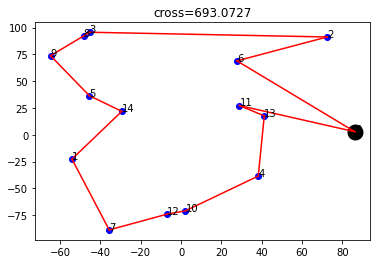

In [7]:
model_saa = SAA()
model_saa.run_saa(N, Mat)

----------------------------------------
1021.2659914712588
[0, 11, 8, 2, 6, 3, 5, 9, 14, 1, 13, 10, 12, 7, 4, 0]
----------------------------------------
987.6155472177581
[0, 4, 13, 5, 3, 1, 12, 10, 7, 14, 9, 8, 11, 6, 2, 0]
----------------------------------------
967.6356062107324
[0, 4, 13, 5, 8, 3, 1, 12, 10, 7, 14, 9, 11, 6, 2, 0]
----------------------------------------
967.6356062107324
[0, 4, 13, 5, 8, 3, 1, 12, 10, 7, 14, 9, 11, 6, 2, 0]
----------------------------------------
965.3185634934324
[0, 4, 7, 12, 10, 1, 8, 3, 14, 5, 11, 13, 2, 6, 9, 0]
----------------------------------------
902.2717541469556
[0, 4, 1, 5, 8, 9, 3, 14, 10, 12, 7, 6, 2, 11, 13, 0]
----------------------------------------
902.2717541469556
[0, 4, 1, 5, 8, 9, 3, 14, 10, 12, 7, 6, 2, 11, 13, 0]
----------------------------------------
902.2717541469556
[0, 4, 1, 5, 8, 9, 3, 14, 10, 12, 7, 6, 2, 11, 13, 0]
----------------------------------------
879.925667194309
[0, 13, 11, 6, 2, 8, 9, 5, 14, 3, 10,

634.190036987699
[0, 4, 10, 12, 7, 1, 14, 5, 9, 8, 3, 6, 2, 11, 13, 0]
----------------------------------------
634.190036987699
[0, 4, 10, 12, 7, 1, 14, 5, 9, 8, 3, 6, 2, 11, 13, 0]
----------------------------------------
634.190036987699
[0, 4, 10, 12, 7, 1, 14, 5, 9, 8, 3, 6, 2, 11, 13, 0]
----------------------------------------
634.190036987699
[0, 4, 10, 12, 7, 1, 14, 5, 9, 8, 3, 6, 2, 11, 13, 0]
----------------------------------------
634.190036987699
[0, 4, 10, 12, 7, 1, 14, 5, 9, 8, 3, 6, 2, 11, 13, 0]
----------------------------------------
634.190036987699
[0, 4, 10, 12, 7, 1, 14, 5, 9, 8, 3, 6, 2, 11, 13, 0]
----------------------------------------
634.190036987699
[0, 4, 10, 12, 7, 1, 14, 5, 9, 8, 3, 6, 2, 11, 13, 0]
----------------------------------------
634.190036987699
[0, 4, 10, 12, 7, 1, 14, 5, 9, 8, 3, 6, 2, 11, 13, 0]
----------------------------------------
634.190036987699
[0, 4, 10, 12, 7, 1, 14, 5, 9, 8, 3, 6, 2, 11, 13, 0]
---------------------------------

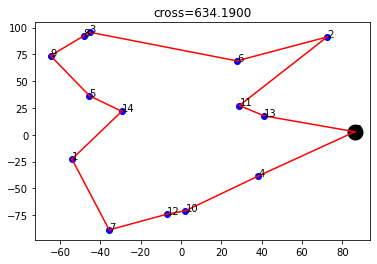

In [8]:
model_ga = GA(N, Mat, 5000)

for x in range(100):
    print('-'*40)
    model_ga.evolve()
    model_ga.result()
    
model_ga.make_gif()

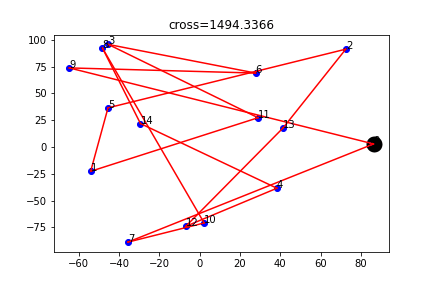

In [9]:
with open('TSP-SAA.gif','rb') as file:
    display(Image(file.read()))

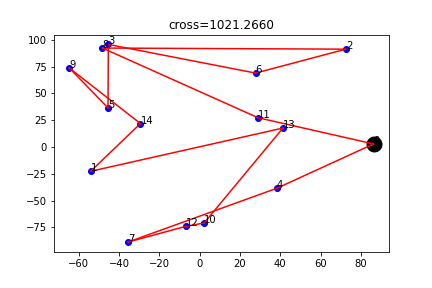

In [10]:
with open('TSP-GA.gif','rb') as file:
    display(Image(file.read()))